<a href="https://colab.research.google.com/github/sunandhini96/ERA_S9/blob/main/ERA_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a new network that
has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
total RF must be more than 44

one of the layers must use Depthwise Separable Convolution

one of the layers must use Dilated Convolution

use GAP (compulsory):- add FC after GAP to target #of classes (optional)

use albumentation library and apply:
horizontal flip
shiftScaleRotate
coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)

achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

In [1]:
!git clone https://github.com/sunandhini96/ERA_S9.git

Cloning into 'ERA_S9'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 40 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (40/40), 243.01 KiB | 4.05 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
cd /content/ERA_S9

/content/ERA_S9


In [3]:
pwd

'/content/ERA_S9'

In [4]:
!python model.py

## importing model

In [5]:
from model import *

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## defining train and test transformations

In [9]:

mean=(0.4914, 0.4822, 0.4465)
std=(0.2470, 0.2435, 0.2616)
def train_transform_function(mean,std):
    train_transform = A.Compose([A.Normalize(mean,std,always_apply=True),
                                 #A.PadIfNeeded(min_height=40,min_width=40,always_apply=True),
                                 #A.RandomCrop(height=32,width=32,always_apply=True),
                                 A.HorizontalFlip(),
                                 A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,rotate_limit=15,p=0.5),
                                 A.CoarseDropout(max_holes=1,max_height=16,max_width=16, min_holes=1, min_height=16,min_width=16, fill_value=mean, mask_fill_value = None),
                                 ToTensorV2()

                                       ])
    return lambda img:train_transform(image=np.array(img))["image"]

In [10]:


# Test Phase transformations
def test_transform_function(mean,std):
      test_transform = A.Compose([
                                            #  transforms.Resize((28, 28)),
                                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),

                                            #transforms.ToTensor(),
                                            A.Normalize(mean,std),
                                            ToTensorV2()
                                            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                            ])
      return lambda img:test_transform(image=np.array(img))["image"]


In [11]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_function(mean,std))
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_function(mean,std))

100%|██████████| 170498071/170498071 [00:05<00:00, 29610015.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Visualization

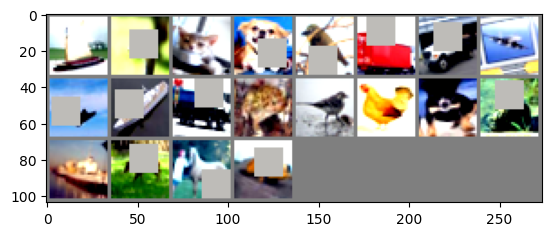

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:20]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(20)))

## Summary of the Model

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6           [-1, 64, 32, 32]           2,048
depthwise_separable_conv-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]          18,432
           Conv2d-12           [-1, 

## Training the model

In [16]:
from model import train,test

In [17]:
from torch.optim.lr_scheduler import StepLR
#from torch_lr_finder import LRFinder

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5757849216461182 Batch_id=97 Accuracy=33.80: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 1.5012, Accuracy: 4462/10000 (44.62%)

EPOCH: 1


Loss=1.4008125066757202 Batch_id=97 Accuracy=46.31: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 1.2715, Accuracy: 5320/10000 (53.20%)

EPOCH: 2


Loss=1.282279372215271 Batch_id=97 Accuracy=52.95: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]



Test set: Average loss: 1.2141, Accuracy: 5653/10000 (56.53%)

EPOCH: 3


Loss=1.1450014114379883 Batch_id=97 Accuracy=56.37: 100%|██████████| 98/98 [00:22<00:00,  4.32it/s]



Test set: Average loss: 1.0374, Accuracy: 6258/10000 (62.58%)

EPOCH: 4


Loss=1.0916813611984253 Batch_id=97 Accuracy=59.44: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.9412, Accuracy: 6674/10000 (66.74%)

EPOCH: 5


Loss=1.0559911727905273 Batch_id=97 Accuracy=61.97: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.8952, Accuracy: 6836/10000 (68.36%)

EPOCH: 6


Loss=1.0382226705551147 Batch_id=97 Accuracy=64.31: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.8471, Accuracy: 7024/10000 (70.24%)

EPOCH: 7


Loss=0.947790801525116 Batch_id=97 Accuracy=65.83: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.7665, Accuracy: 7282/10000 (72.82%)

EPOCH: 8


Loss=0.9242296814918518 Batch_id=97 Accuracy=67.05: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.7646, Accuracy: 7308/10000 (73.08%)

EPOCH: 9


Loss=0.9834792017936707 Batch_id=97 Accuracy=68.37: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.7805, Accuracy: 7296/10000 (72.96%)

EPOCH: 10


Loss=0.9432013630867004 Batch_id=97 Accuracy=69.32: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.6843, Accuracy: 7606/10000 (76.06%)

EPOCH: 11


Loss=0.8871675133705139 Batch_id=97 Accuracy=70.33: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.6749, Accuracy: 7635/10000 (76.35%)

EPOCH: 12


Loss=0.8986826539039612 Batch_id=97 Accuracy=71.01: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.6903, Accuracy: 7617/10000 (76.17%)

EPOCH: 13


Loss=0.8089399933815002 Batch_id=97 Accuracy=71.78: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.6261, Accuracy: 7811/10000 (78.11%)

EPOCH: 14


Loss=0.7297646403312683 Batch_id=97 Accuracy=72.61: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.6223, Accuracy: 7857/10000 (78.57%)

EPOCH: 15


Loss=0.7751535773277283 Batch_id=97 Accuracy=72.78: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.6011, Accuracy: 7920/10000 (79.20%)

EPOCH: 16


Loss=0.8007113337516785 Batch_id=97 Accuracy=73.07: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.6000, Accuracy: 7942/10000 (79.42%)

EPOCH: 17


Loss=0.6645008325576782 Batch_id=97 Accuracy=73.79: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.5840, Accuracy: 7985/10000 (79.85%)

EPOCH: 18


Loss=0.8452221751213074 Batch_id=97 Accuracy=74.07: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.6037, Accuracy: 7911/10000 (79.11%)

EPOCH: 19


Loss=0.7903329730033875 Batch_id=97 Accuracy=74.55: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.5618, Accuracy: 8053/10000 (80.53%)

EPOCH: 20


Loss=0.7770638465881348 Batch_id=97 Accuracy=74.93: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.5784, Accuracy: 8021/10000 (80.21%)

EPOCH: 21


Loss=0.6116175651550293 Batch_id=97 Accuracy=75.07: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.5646, Accuracy: 8075/10000 (80.75%)

EPOCH: 22


Loss=0.6473553776741028 Batch_id=97 Accuracy=75.78: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.5583, Accuracy: 8110/10000 (81.10%)

EPOCH: 23


Loss=0.6496868133544922 Batch_id=97 Accuracy=76.04: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.5260, Accuracy: 8173/10000 (81.73%)

EPOCH: 24


Loss=0.7345458269119263 Batch_id=97 Accuracy=76.17: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.5383, Accuracy: 8188/10000 (81.88%)

EPOCH: 25


Loss=0.6171005964279175 Batch_id=97 Accuracy=76.46: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.5232, Accuracy: 8183/10000 (81.83%)

EPOCH: 26


Loss=0.5854296088218689 Batch_id=97 Accuracy=76.82: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.5173, Accuracy: 8251/10000 (82.51%)

EPOCH: 27


Loss=0.6181892156600952 Batch_id=97 Accuracy=77.21: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.5383, Accuracy: 8152/10000 (81.52%)

EPOCH: 28


Loss=0.6208509802818298 Batch_id=97 Accuracy=77.47: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.5265, Accuracy: 8189/10000 (81.89%)

EPOCH: 29


Loss=0.5899529457092285 Batch_id=97 Accuracy=77.51: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.5022, Accuracy: 8262/10000 (82.62%)

EPOCH: 30


Loss=0.7028959393501282 Batch_id=97 Accuracy=77.72: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.4982, Accuracy: 8290/10000 (82.90%)

EPOCH: 31


Loss=0.6226779222488403 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.5082, Accuracy: 8266/10000 (82.66%)

EPOCH: 32


Loss=0.5788058042526245 Batch_id=97 Accuracy=77.96: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.5061, Accuracy: 8276/10000 (82.76%)

EPOCH: 33


Loss=0.6330087780952454 Batch_id=97 Accuracy=78.34: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.4865, Accuracy: 8322/10000 (83.22%)

EPOCH: 34


Loss=0.6951746940612793 Batch_id=97 Accuracy=78.81: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4938, Accuracy: 8334/10000 (83.34%)

EPOCH: 35


Loss=0.5794070363044739 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.4763, Accuracy: 8361/10000 (83.61%)

EPOCH: 36


Loss=0.6278604865074158 Batch_id=97 Accuracy=78.70: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.4824, Accuracy: 8360/10000 (83.60%)

EPOCH: 37


Loss=0.5048085451126099 Batch_id=97 Accuracy=79.01: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4795, Accuracy: 8384/10000 (83.84%)

EPOCH: 38


Loss=0.598193347454071 Batch_id=97 Accuracy=78.99: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4691, Accuracy: 8412/10000 (84.12%)

EPOCH: 39


Loss=0.6966530680656433 Batch_id=97 Accuracy=79.21: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.4744, Accuracy: 8372/10000 (83.72%)

EPOCH: 40


Loss=0.6283212304115295 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.4608, Accuracy: 8446/10000 (84.46%)

EPOCH: 41


Loss=0.6217731833457947 Batch_id=97 Accuracy=79.76: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.4547, Accuracy: 8475/10000 (84.75%)

EPOCH: 42


Loss=0.5750888586044312 Batch_id=97 Accuracy=79.80: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.4612, Accuracy: 8428/10000 (84.28%)

EPOCH: 43


Loss=0.6153951287269592 Batch_id=97 Accuracy=79.79: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.4544, Accuracy: 8442/10000 (84.42%)

EPOCH: 44


Loss=0.5760239958763123 Batch_id=97 Accuracy=80.04: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.4388, Accuracy: 8491/10000 (84.91%)

EPOCH: 45


Loss=0.5456974506378174 Batch_id=97 Accuracy=80.25: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.4557, Accuracy: 8459/10000 (84.59%)

EPOCH: 46


Loss=0.5574885010719299 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.4388, Accuracy: 8519/10000 (85.19%)

EPOCH: 47


Loss=0.5154080390930176 Batch_id=97 Accuracy=80.73: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.4446, Accuracy: 8474/10000 (84.74%)

EPOCH: 48


Loss=0.6603943109512329 Batch_id=97 Accuracy=80.42: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4364, Accuracy: 8502/10000 (85.02%)

EPOCH: 49


Loss=0.4878547787666321 Batch_id=97 Accuracy=80.82: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.4318, Accuracy: 8524/10000 (85.24%)



In [18]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [19]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
# print("conv_layers")

Total convolution layers: 9


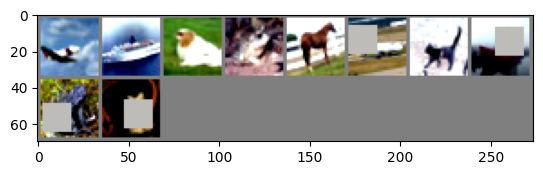

In [20]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

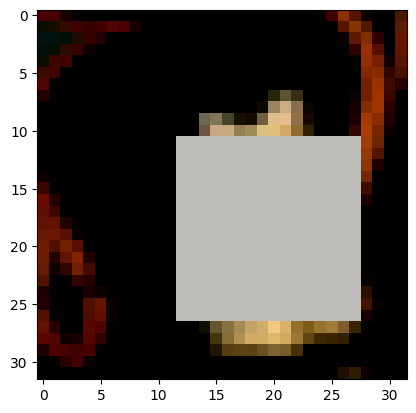

In [21]:
image = images[9]
imshow(image)

In [22]:
image = image.unsqueeze(0)
image = image.to(device)

## Loss and Accuracy curves

Text(0.5, 1.0, 'Test Accuracy')

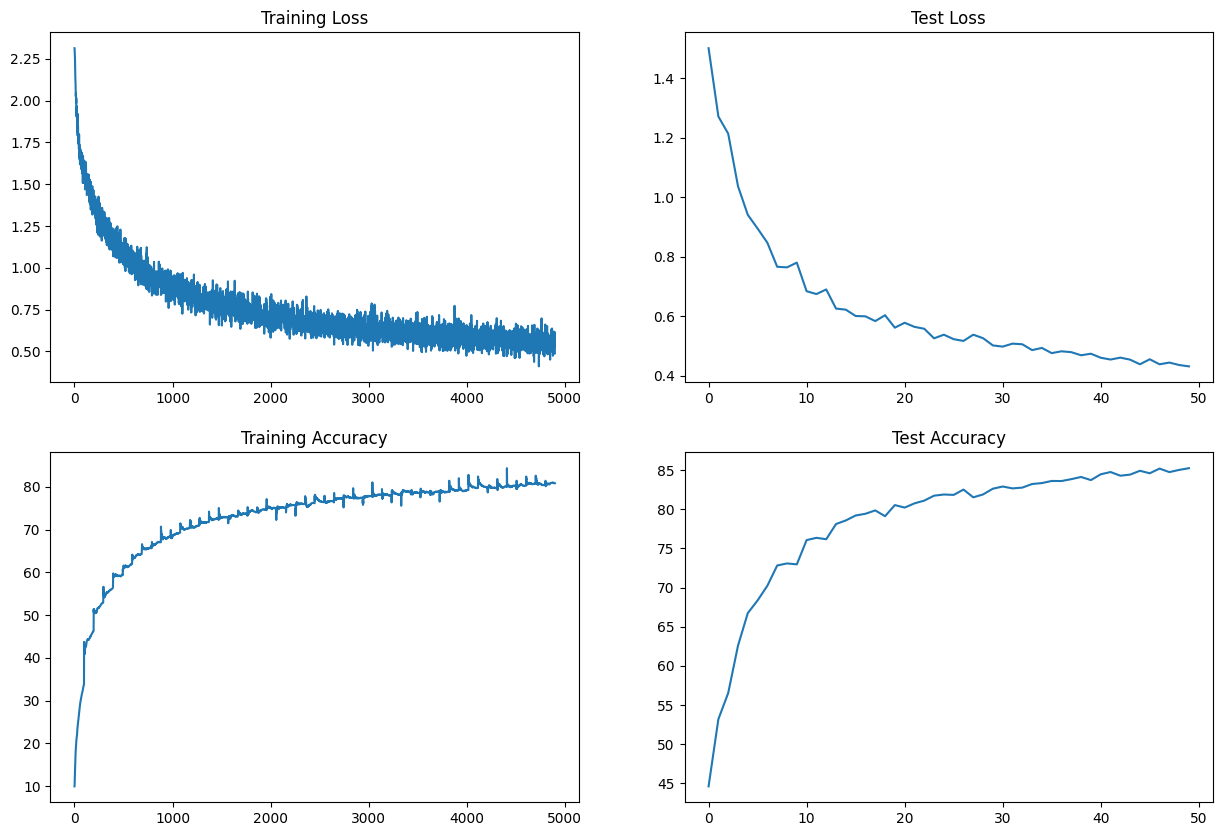

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")